# Imports

In [12]:
import time
import copy
import torch
import random
import torchvision
import tarfile, requests, os

import numpy as np
import ipywidgets as widgets
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets

from tqdm.auto import tqdm

# Helper functions

In [2]:
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/content-creation/main/nma.mplstyle")
plt.rc('axes', unicode_minus=False)

In [4]:
def print_params(model):
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(name, param.data)

In [31]:
def loss_2d(model, u, v, mask_idx=(0, 378), bias_id=7):
    """Defines a 2-dim function by freezing all but two parameters of a linear
    model.

    Args:
    model (torch module): a pytorch 0-hidden layer (linear) model
    u (scalar): first free parameter
    v (scalar): second free parameter
    mask_idx (tuple): selects parameter in weight matrix replaced by u
    bias_idx (int): selects parameter in bias vector replaced by v

    Returns:
    scalar: loss of the 'new' model over inputs X, y (defined externally)
    """

    # We zero out the element of the weight tensor that will be
    # replaced by u
    mask = torch.ones_like(model.main[0].weight)
    mask[mask_idx[0], mask_idx[1]] = 0.
    masked_weights = model.main[0].weight * mask

    # u is replacing an element of the weight matrix
    masked_weights[mask_idx[0], mask_idx[1]] = u

    res = X.reshape(-1, 784) @ masked_weights.T + model.main[0].bias

    # v is replacing a bias for class 7
    res[:, 7] += v - model.main[0].bias[7]
    res =  F.log_softmax(res, dim=1)

    return loss_fn(res, y)


def plot_surface(U, V, Z, fig):
    """ Plot a 3D loss surface given meshed inputs U, V and values Z
    """
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    ax.view_init(45, -130)

    surf = ax.plot_surface(U, V, Z, cmap=plt.cm.coolwarm,
                      linewidth=0, antialiased=True, alpha=0.5)

    # Select certain level contours to plot
    # levels = Z.min() * np.array([1.005, 1.1, 1.3, 1.5, 2.])
    # plt.contour(U, V, Z)# levels=levels, alpha=0.5)

    ax.set_xlabel('Weight')
    ax.set_ylabel('Bias')
    ax.set_zlabel('Loss', rotation=90)

    return ax


def plot_param_distance(best_u, best_v, trajs, fig, styles, labels,
                        use_log=False, y_min_v=-12.0, y_max_v=1.5):
    """ Plot the distance to each of the two parameters for a collection of 'trajectories'
    """
    ax = fig.add_subplot(1, 1, 1)

    for traj, style, label in zip(trajs, styles, labels):
        d0 = np.array([np.abs(_[0] - best_u) for _ in traj])
        d1 = np.array([np.abs(_[1] - best_v) for _ in traj])
        if use_log:
            d0 = np.log(1e-16 + d0)
            d1 = np.log(1e-16 + d1)
        ax.plot(range(len(traj)), d0, style, label='weight - ' + label)
        ax.plot(range(len(traj)), d1, style, label='bias - ' + label)
    ax.set_xlabel('Iteration')
    if use_log:
        ax.set_ylabel('Log distance to optimum (per dimension)')
        ax.set_ylim(y_min_v, y_max_v)
    else:
        ax.set_ylabel('Abs distance to optimum (per dimension)')
        ax.legend(loc='right', bbox_to_anchor=(1.5, 0.5),
            fancybox=False, shadow=False, ncol=1)

    return ax


def run_optimizer(inits, eval_fn, update_fn, max_steps=500,
                  optim_kwargs={'lr':1e-2}, log_traj=True):
    """Runs an optimizer on a given objective and logs parameter trajectory

    Args:
      inits list(scalar): initialization of parameters
      eval_fn (callable): function computing the objective to be minimized
      update_fn (callable): function executing parameter update
      max_steps (int): number of iterations to run
      optim_kwargs (dict): customize optimizer hyperparameters

    Returns:
      list[list]: trajectory information [*params, loss] for each optimization step
    """

    # Initialize parameters and optimizer
    params = [nn.Parameter(torch.tensor(_)) for _ in inits]
    # Methods like momentum and rmsprop keep and auxiliary vector of parameters
    aux_tensors = [torch.zeros_like(_) for _ in params]
    if log_traj:
        traj = np.zeros((max_steps, len(params)+1))
    for _ in range(max_steps):
        # Evaluate loss
        loss = eval_fn(*params)
        # Store 'trajectory' information
        if log_traj:
            traj[_, :] = [_.item() for _ in params] + [loss.item()]
        # Perform update
        if update_fn == gradient_update:
            gradient_update(loss, params, **optim_kwargs)
        else:
            update_fn(loss, params, aux_tensors, **optim_kwargs)
    if log_traj:
        return traj

L = 4.
xs = np.linspace(-L, L, 30)
ys = np.linspace(-L, L, 30)
U, V = np.meshgrid(xs, ys)

In [5]:
def set_seed(seed=None, seed_torch=True):
    if seed is None:
        seed = np.random.choice(2 ** 32)
    random.seed(seed)
    np.random.seed(seed)
    if seed_torch:
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

    print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

In [6]:
def set_device():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    return device

In [9]:
SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 2021 has been set.


# Successfully training an MLP for Image Classification

## Download MNIST dataset

In [14]:
fname = 'MNIST.tar.gz'
name = 'MNIST'
url = 'https://osf.io/y2fj6/download'

if not os.path.exists(name):
    print('\nDownloading MNIST dataset...')
    r = requests.get(url, allow_redirects=True)
    with open(fname, 'wb') as fh:
        fh.write(r.content)
    print('\nDownloading MNIST completed.')

if not os.path.exists(name):
    with tarfile.open(fname) as tar:
        tar.extractall()
        os.remove(fname)
else:
    print('MNIST dataset has been dowloaded.')

MNIST dataset has been dowloaded.


In [17]:
def load_mnist_data(change_tensors=False, download=False):
    """Load training and test examples for the MNIST digits dataset

    Returns:
    train_data (tensor): training input tensor of size (train_size x 784)
    train_target (tensor): training 0-9 integer label tensor of size (train_size)
    test_data (tensor): test input tensor of size (70k-train_size x 784)
    test_target (tensor): training 0-9 integer label tensor of size (70k-train_size)

    """
    # Load train and test sets
    train_set = datasets.MNIST(root='.', train=True, download=download,
                             transform=torchvision.transforms.ToTensor())
    test_set = datasets.MNIST(root='.', train=False, download=download,
                            transform=torchvision.transforms.ToTensor())

    # Original data is in range [0, 255]. We normalize the data wrt its mean and std_dev.
    ## Note that we only used *training set* information to compute mean and std
    mean = train_set.data.float().mean()
    std = train_set.data.float().std()

    if change_tensors:
        # Apply normalization directly to the tensors containing the dataset
        train_set.data = (train_set.data.float() - mean) / std
        test_set.data = (test_set.data.float() - mean) / std
    else:
        tform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                torchvision.transforms.Normalize(mean=[mean / 255.], std=[std / 255.])
                                                ])
        train_set = datasets.MNIST(root='.', train=True, download=download,
                                   transform=tform)
        test_set = datasets.MNIST(root='.', train=False, download=download,
                                  transform=tform)

    return train_set, test_set

train_set, test_set = load_mnist_data(change_tensors=True,download=True)

Failed to download (trying next):
HTTP Error 503: Service Unavailable



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Using downloaded and verified file: ./MNIST/raw/train-labels-idx1-ubyte.gz
Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Using downloaded and verified file: ./MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Using downloaded and verified file: ./MNIST/raw/t10k-labels-idx1-ubyte.gz
Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

Processing...
Done!


/opt/homebrew/Caskroom/miniforge/base/envs/nma/lib/python3.9/site-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /tmp/pip-req-build-q81c20j3/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [19]:
# Sample a random subset of 500 indices
subset_index = np.random.choice(len(train_set.data), 500)

# We will use these symbols to represent the training data and labels, to stay
# as close to the mathematical expressions as possible.
X, y = train_set.data[subset_index, :], train_set.targets[subset_index]

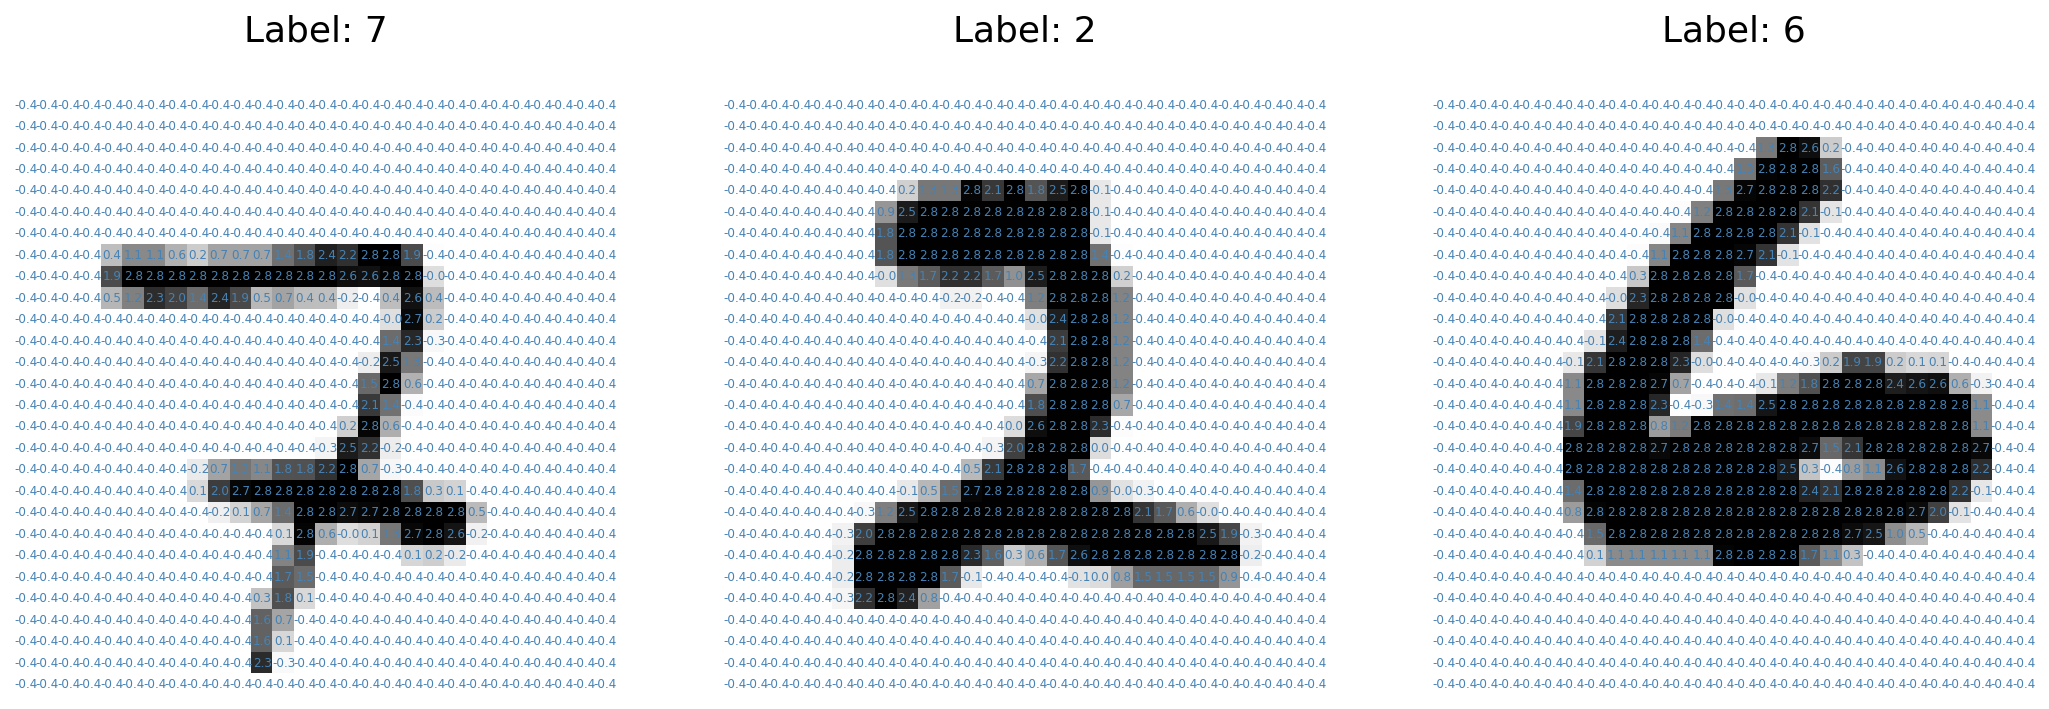

In [20]:
# visualize training set
num_figures = 3
fig, axs = plt.subplots(1, num_figures, figsize=(5 * num_figures, 5))

for sample_id, ax in enumerate(axs):
    # Plot the pixel values for each image
    ax.matshow(X[sample_id, :], cmap='gray_r')
    # 'Write' the pixel value in the corresponding location
    for (i, j), z in np.ndenumerate(X[sample_id, :]):
        text = '{:.1f}'.format(z)
        ax.text(j, i, text, ha='center',
                va='center', fontsize=6, c='steelblue')

    ax.set_title('Label: ' + str(y[sample_id].item()))
    ax.axis('off')

plt.show()

## Model

In [22]:
class MLP(nn.Module):
    """ This class implements MLPs in Pytorch of an arbitrary number of hidden
    layers of potentially different sizes. Since we concentrate on classification
    tasks in this tutorial, we have a log_softmax layer at prediction time.
    """

    def __init__(self, in_dim=784, out_dim=10, hidden_dims=[], use_bias=True):
        """Constructs a MultiLayerPerceptron

        Args:
            in_dim (int): dimensionality of input data
            out_dim (int): number of classes
            hidden_dims (list): contains the dimensions of the hidden layers, an empty
                list corresponds to a linear model (in_dim, out_dim)
        """

        super(MLP, self).__init__()

        self.in_dim = in_dim
        self.out_dim = out_dim

        # If we have no hidden layer, just initialize a linear model (e.g. in logistic regression)
        if len(hidden_dims) == 0:
            layers = [nn.Linear(in_dim, out_dim, bias=use_bias)]
        else:
            # 'Actual' MLP with dimensions in_dim - num_hidden_layers*[hidden_dim] - out_dim
            layers = [nn.Linear(in_dim, hidden_dims[0], bias=use_bias), nn.ReLU()]

            # Loop until before the last layer
            for i, hidden_dim in enumerate(hidden_dims[:-1]):
                layers += [nn.Linear(hidden_dim, hidden_dims[i + 1], bias=use_bias),
                       nn.ReLU()]

            # Add final layer to the number of classes
            layers += [nn.Linear(hidden_dims[-1], out_dim, bias=use_bias)]

        self.main = nn.Sequential(*layers)

    def forward(self, x):
        # Flatten the images into 'vectors'
        transformed_x = x.view(-1, self.in_dim)
        hidden_output = self.main(transformed_x)
        output = F.log_softmax(hidden_output, dim=1)
        return output

Linear models constitute a very special kind of MLPs: they are equivalent to an MLP with *zero* hidden layers. This is simply an affine transformation, in other words a 'linear' map $W x$ with an 'offset' $b$; followed by a softmax function.

$$f(x) = \text{softmax}(W x + b)$$

Here $x \in \mathbb{R}^{784}$, $W \in \mathbb{R}^{10 \times 784}$ and $b \in \mathbb{R}^{10}$. Notice that the dimensions of the weight matrix are $10 \times 784$ as the input tensors are flattened images, i.e., $28 \times 28 = 784$-dimensional tensors and the output layer consists of $10$ nodes.

In [23]:
# Empty hidden_dims means we take a model with zero hidden layers.
model = MLP(in_dim=784, out_dim=10, hidden_dims=[])

# We print the model structure with 784 inputs and 10 outputs
print(model)

MLP(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=10, bias=True)
  )
)


## Loss

While we care about the accuracy of the model, the 'discrete' nature of the 0-1 loss makes it challenging to optimize. In order to learn good parameters for this model, we will use the cross entropy loss (negative log-likelihood), which you saw in last lecture, as a surrogate objective to be minimized. 

This particular choice of model and optimization objective leads to a *convex* optimization problem with respect to the parameters $W$ and $b$. 

In [24]:
loss_fn = F.nll_loss

## Interpretability

### Train the model

In [25]:
cell_verbose = False
partial_trained_model = MLP(in_dim=784, out_dim=10, hidden_dims=[])

if cell_verbose:
    print('Init loss', loss_fn(partial_trained_model(X), y).item()) # This matches around np.log(10 = # of classes)

optimizer = optim.Adam(partial_trained_model.parameters(), lr=7e-4)
for _ in range(200):
    loss = loss_fn(partial_trained_model(X), y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

if cell_verbose:
    print('End loss', loss_fn(partial_trained_model(X), y).item()) # This should be less than 1e-2

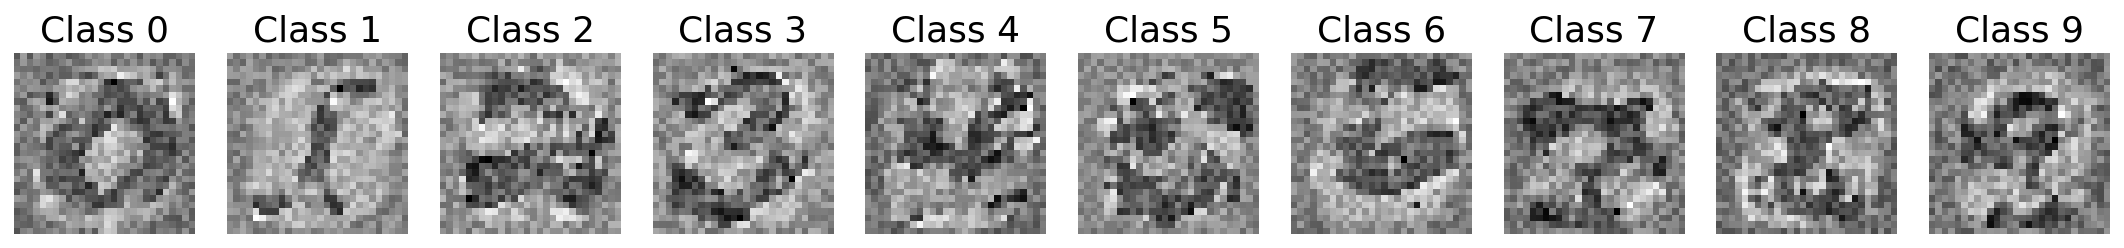

In [26]:
# Show class filters of a trained model
W = partial_trained_model.main[0].weight.data.numpy()

fig, axs = plt.subplots(1, 10, figsize=(15, 4))
for class_id in range(10):
    axs[class_id].imshow(W[class_id, :].reshape(28, 28), cmap='gray_r')
    axs[class_id].axis('off')
    axs[class_id].set_title('Class ' + str(class_id))

plt.show()

# High Dimensional Search

## Gradient Descent

In [28]:
def zero_grad(params):
    """Clear up gradients as Pytorch automatically accumulates gradients from
    successive backward calls
    """
    for par in params:
        if not(par.grad is None):
            par.grad.data.zero_()


def random_update(model, noise_scale=0.1, normalized=False):
    """ Performs a random update on the parameters of the model
    """
    for par in model.parameters():
        noise = torch.randn_like(par)
        if normalized:
            noise /= torch.norm(noise)
        par.data +=  noise_scale * noise

In [29]:
def gradient_update(loss, params, lr=1e-3):
    """Perform a gradient descent update on a given loss over a collection of parameters

    Args:
    loss (tensor): A scalar tensor containing the loss whose gradient will be computed
    params (iterable): Collection of parameters with respect to which we compute gradients
    lr (float): Scalar specifying the learning rate or step-size for the update
    """
    # Clear up gradients as Pytorch automatically accumulates gradients from
    # successive backward calls
    zero_grad(params)

    # Compute gradients on given objective
    loss.backward()

    with torch.no_grad():
        for par in params:
            # Here we work with the 'data' attribute of the parameter rather than the
            # parameter itself.
            par.data -= lr * par.grad.data

set_seed(seed=SEED)
model1 = MLP(in_dim=784, out_dim=10, hidden_dims=[])
print('\n The model1 parameters before the update are: \n')
print_params(model1)
loss = loss_fn(model1(X), y)

gradient_update(loss, list(model1.parameters()), lr=1e-1)
print('\n The model1 parameters after the update are: \n')
print_params(model1)

Random seed 2021 has been set.

 The model1 parameters before the update are: 

main.0.weight tensor([[-0.0264,  0.0010,  0.0173,  ...,  0.0297,  0.0278, -0.0221],
        [-0.0040, -0.0295, -0.0086,  ..., -0.0070,  0.0254, -0.0233],
        [ 0.0240, -0.0231,  0.0342,  ...,  0.0124,  0.0270, -0.0180],
        ...,
        [-0.0005,  0.0157,  0.0111,  ...,  0.0144, -0.0301, -0.0144],
        [ 0.0181,  0.0303,  0.0255,  ..., -0.0110, -0.0175,  0.0205],
        [ 0.0208, -0.0353, -0.0183,  ..., -0.0271,  0.0099,  0.0003]])
main.0.bias tensor([-0.0290, -0.0033,  0.0100, -0.0320,  0.0022,  0.0221,  0.0307,  0.0243,
         0.0159, -0.0064])

 The model1 parameters after the update are: 

main.0.weight tensor([[-0.0263,  0.0010,  0.0174,  ...,  0.0298,  0.0278, -0.0220],
        [-0.0047, -0.0302, -0.0093,  ..., -0.0077,  0.0248, -0.0240],
        [ 0.0234, -0.0237,  0.0335,  ...,  0.0117,  0.0263, -0.0187],
        ...,
        [-0.0006,  0.0156,  0.0110,  ...,  0.0143, -0.0302, -0.0145]

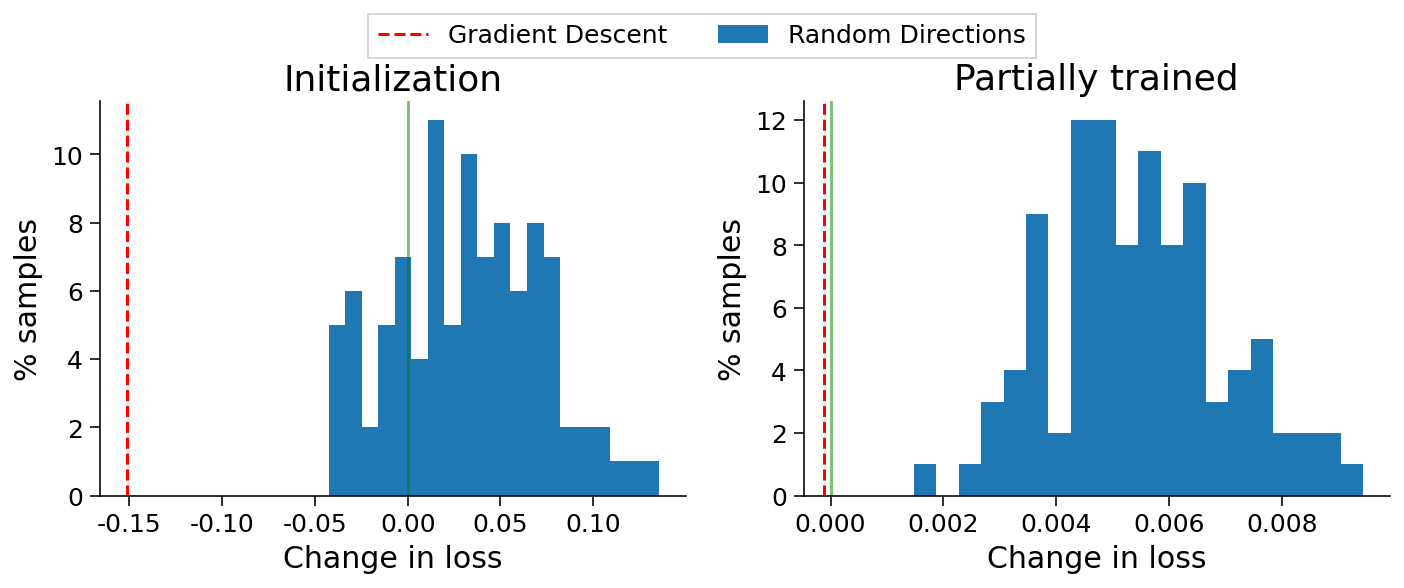

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
for id, (model_name, my_model) in enumerate([('Initialization', model),
                                              ('Partially trained', partial_trained_model)]):
    # Compue the loss we will be comparing to
    base_loss = loss_fn(my_model(X), y)

    # Compute the improvement via gradient descent
    dummy_model = copy.deepcopy(my_model)
    loss1 = loss_fn(dummy_model(X), y)
    gradient_update(loss1, list(dummy_model.parameters()), lr=1e-2)
    gd_delta = loss_fn(dummy_model(X), y) - base_loss

    deltas = []
    for trial_id in range(100):
        # Compute the improvement obtained with a random direction
        dummy_model = copy.deepcopy(my_model)
        random_update(dummy_model, noise_scale=1e-2)
        deltas.append((loss_fn(dummy_model(X), y) - base_loss).item())

    # Plot histogram for random direction and vertical line for gradient descent
    axs[id].hist(deltas, label='Random Directions', bins=20)
    axs[id].set_title(model_name)
    axs[id].set_xlabel('Change in loss')
    axs[id].set_ylabel('% samples')
    axs[id].axvline(0, c='green', alpha=0.5)
    axs[id].axvline(gd_delta.item(), linestyle='--', c='red', alpha=1,
                  label='Gradient Descent')


handles, labels = axs[id].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center',
           bbox_to_anchor=(0.5, 1.05),
           fancybox=False, shadow=False, ncol=2)

plt.show()

# Poor Conditioning

Momentum update is given by:

\begin{equation}
w_{t+1} = w_t - \eta \nabla J(w_t) + \beta (w_t - w_{t-1})
\end{equation}

It is convenient to re-express this update rule in terms of a recursion. For that, we define 'velocity' as the quantity:
\begin{equation}
v_{t-1} := w_{t} - w_{t-1}
\end{equation}

which leads to the two-step update rule:

\begin{equation}
v_t = - \eta \nabla J(w_t) + \beta (\underbrace{w_t - w_{t-1}}_{v_{t-1}})
\end{equation}

\begin{equation}
w_{t+1} \leftarrow w_t + v_{t}
\end{equation}

Pay attention to the positive sign of the update in the last equation, given the definition of $v_t$, above. 

In [32]:
def momentum_update(loss, params, grad_vel, lr=1e-3, beta=0.8):
    """Perform a momentum update over a collection of parameters given a loss and 'velocities'

    Args:
    loss (tensor): A scalar tensor containing the loss whose gradient will be computed
    params (iterable): Collection of parameters with respect to which we compute gradients
    grad_vel (iterable): Collection containing the 'velocity' v_t for each parameter
    lr (float): Scalar specifying the learning rate or step-size for the update
    beta (float): Scalar 'momentum' parameter
    """
    # Clear up gradients as Pytorch automatically accumulates gradients from
    # successive backward calls
    zero_grad(params)
    # Compute gradients on given objective
    loss.backward()

    with torch.no_grad():
        for (par, vel) in zip(params, grad_vel):
          # Update 'velocity'
          vel.data = -lr * par.grad.data + beta * vel.data
          # Update parameters
          par.data += vel.data

set_seed(seed=SEED)
model2 = MLP(in_dim=784, out_dim=10, hidden_dims=[])
print('\n The model2 parameters before the update are: \n')
print_params(model2)
loss = loss_fn(model2(X), y)
initial_vel = [torch.randn_like(p) for p in model2.parameters()]
momentum_update(loss, list(model2.parameters()), grad_vel=initial_vel, lr=1e-1, beta=0.9)
print('\n The model2 parameters after the update are: \n')
print_params(model2)

Random seed 2021 has been set.

 The model2 parameters before the update are: 

main.0.weight tensor([[-0.0264,  0.0010,  0.0173,  ...,  0.0297,  0.0278, -0.0221],
        [-0.0040, -0.0295, -0.0086,  ..., -0.0070,  0.0254, -0.0233],
        [ 0.0240, -0.0231,  0.0342,  ...,  0.0124,  0.0270, -0.0180],
        ...,
        [-0.0005,  0.0157,  0.0111,  ...,  0.0144, -0.0301, -0.0144],
        [ 0.0181,  0.0303,  0.0255,  ..., -0.0110, -0.0175,  0.0205],
        [ 0.0208, -0.0353, -0.0183,  ..., -0.0271,  0.0099,  0.0003]])
main.0.bias tensor([-0.0290, -0.0033,  0.0100, -0.0320,  0.0022,  0.0221,  0.0307,  0.0243,
         0.0159, -0.0064])

 The model2 parameters after the update are: 

main.0.weight tensor([[ 1.5898,  0.0116, -2.0239,  ..., -1.0871,  0.4030, -0.9577],
        [ 0.4653,  0.6022, -0.7363,  ...,  0.5485, -0.2747, -0.6539],
        [-1.4117, -1.1045,  0.6492,  ..., -1.0201,  0.6503,  0.1310],
        ...,
        [-0.5098,  0.5075, -0.0718,  ...,  1.1192,  0.2900, -0.9657]

# Non-convexity

Use the interactive plot below to visualize the loss progression for these perturbed models:

1. Select different settings from the `hidden_dims` drop-down menu.
2. Explore the effect of the number of steps and learning rate.

In [33]:
@widgets.interact_manual
def overparam(max_steps=widgets.IntSlider(150, 50, 500, 5),
              hidden_dims=widgets.Dropdown(options=["10", "20, 20", "100, 100"],
                                           value="10"),
              lr=widgets.FloatLogSlider(value=5e-2, min=-3, max=0, step=0.1),
              num_inits=widgets.IntSlider(7, 5, 10, 1)):

    X, y = train_set.data[subset_index, :], train_set.targets[subset_index]

    hdims = [int(s) for s in hidden_dims.split(',')]
    base_model = MLP(in_dim=784, out_dim=10, hidden_dims=hdims)

    fig, axs = plt.subplots(1, 1, figsize=(5, 4))

    for _ in tqdm(range(num_inits)):
        model = copy.deepcopy(base_model)
        random_update(model, noise_scale=2e-1)

        loss_hist = np.zeros((max_steps, 2))
        for step in range(max_steps):
            loss = loss_fn(model(X), y)
            gradient_update(loss, list(model.parameters()), lr=lr)
            loss_hist[step] = np.array([step, loss.item()])

        plt.plot(loss_hist[:, 0], loss_hist[:, 1])

    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.ylim(0, 3)
    plt.show()

    num_params = sum([np.prod(_.shape) for _ in model.parameters()])
    print('Number of paramaters in model:  ' + str(num_params))

interactive(children=(IntSlider(value=150, description='max_steps', max=500, min=50, step=5), Dropdown(descrip…

# Full Gradients are Expensive

## Mini-batches

In [34]:
def sample_minibatch(input_data, target_data, num_points=100):
    """Sample a minibatch of size num_point from the provided input-target data

    Args:
    input_data (tensor): Multi-dimensional tensor containing the input data
    target_data (tensor): 1D tensor containing the class labels
    num_points (int): Number of elements to be included in minibatch

    Returns:
    batch_inputs (tensor): Minibatch inputs
    batch_targets (tensor): Minibatch targets
    """
    # Sample a collection of IID indices from the existing data
    batch_indices = np.random.choice(len(input_data), num_points)
    # Use batch_indices to extract entries from the input and target data tensors
    batch_inputs = input_data[batch_indices, :]
    batch_targets = target_data[batch_indices]

    return batch_inputs, batch_targets

x_batch, y_batch = sample_minibatch(X, y, num_points=100)
print(f"The input shape is {x_batch.shape} and the target shape is: {y_batch.shape}")

The input shape is torch.Size([100, 28, 28]) and the target shape is: torch.Size([100])


In [35]:
@widgets.interact_manual
def minibatch_experiment(batch_sizes='20, 250, 1000',
                         lrs='5e-3, 5e-3, 5e-3',
                         time_budget=widgets.Dropdown(options=["2.5", "5", "10"],
                                                      value="2.5")):

    batch_sizes = [int(s) for s in batch_sizes.split(',')]
    lrs = [float(s) for s in lrs.split(',')]

    LOSS_HIST = {_:[] for _ in batch_sizes}

    X, y = train_set.data, train_set.targets
    base_model = MLP(in_dim=784, out_dim=10, hidden_dims=[100, 100])

    for id, batch_size in enumerate(tqdm(batch_sizes)):
        start_time = time.time()
        # Create a new copy of the model for each batch size
        model = copy.deepcopy(base_model)
        params = list(model.parameters())
        lr = lrs[id]
        # Fixed budget per choice of batch size
        while (time.time() - start_time) < float(time_budget):
            data, labels = sample_minibatch(X, y, batch_size)
            loss = loss_fn(model(data), labels)
            gradient_update(loss, params, lr=lr)
            LOSS_HIST[batch_size].append([time.time() - start_time,
                                        loss.item()])

    fig, axs = plt.subplots(1, len(batch_sizes), figsize=(10, 3))
    for ax, batch_size in zip(axs, batch_sizes):
        plot_data = np.array(LOSS_HIST[batch_size])
        ax.plot(plot_data[:, 0], plot_data[:, 1], label=batch_size,
                alpha=0.8)
        ax.set_title('Batch size: ' + str(batch_size))
        ax.set_xlabel('Seconds')
        ax.set_ylabel('Loss')
    plt.show()

interactive(children=(Text(value='20, 250, 1000', description='batch_sizes'), Text(value='5e-3, 5e-3, 5e-3', d…

# Adaptive Methods

Here is the update of the RMSprop optimizer:

\begin{align}
v_{t} &= \alpha v_{t-1} + (1 - \alpha) \nabla J(w_t)^2 \\ \\
w_{t+1} &= w_t - \eta \frac{\nabla J(w_t)}{\sqrt{v_t + \epsilon}}
\end{align}

where the non-standard operations (division of two vectors, squaring a vector, etc) are to be interpreted as element-wise operations, i.e., the operation is applied to each (pair of) entry[ies] of the vector(s) considered as real number(s).

Here, the $\epsilon$ hyperparameter provides numerical estability to the algorithm, by preventing the learning rate to become too big when $v_t$ is small. Typically, we set $\epsilon$ to a default small value, like $10^{-8}$.

In [36]:
def rmsprop_update(loss, params, grad_sq, lr=1e-3, alpha=0.8, epsilon=1e-8):
    """Perform an RMSprop update on a collection of parameters

    Args:
    loss (tensor): A scalar tensor containing the loss whose gradient will be computed
    params (iterable): Collection of parameters with respect to which we compute gradients
    grad_sq (iterable): Moving average of squared gradients
    lr (float): Scalar specifying the learning rate or step-size for the update
    alpha (float): Moving average parameter
    epsilon (float): for numerical estability
    """
    # Clear up gradients as Pytorch automatically accumulates gradients from
    # successive backward calls
    zero_grad(params)
    # Compute gradients on given objective
    loss.backward()

    with torch.no_grad():
        for (par, gsq) in zip(params, grad_sq):
          # Update estimate of gradient variance
          gsq.data = alpha * gsq.data + (1 - alpha) * par.grad**2
          # Update parameters
          par.data -=  lr * (par.grad / (epsilon + gsq.data)**0.5)

set_seed(seed=SEED)
model3 = MLP(in_dim=784, out_dim=10, hidden_dims=[])
print('\n The model3 parameters before the update are: \n')
print_params(model3)
loss = loss_fn(model3(X), y)
# Intialize the moving average of squared gradients
grad_sq = [1e-6*i for i in list(model3.parameters())]

rmsprop_update(loss, list(model3.parameters()), grad_sq=grad_sq, lr=1e-3)
print('\n The model3 parameters after the update are: \n')
print_params(model3)

Random seed 2021 has been set.

 The model3 parameters before the update are: 

main.0.weight tensor([[-0.0264,  0.0010,  0.0173,  ...,  0.0297,  0.0278, -0.0221],
        [-0.0040, -0.0295, -0.0086,  ..., -0.0070,  0.0254, -0.0233],
        [ 0.0240, -0.0231,  0.0342,  ...,  0.0124,  0.0270, -0.0180],
        ...,
        [-0.0005,  0.0157,  0.0111,  ...,  0.0144, -0.0301, -0.0144],
        [ 0.0181,  0.0303,  0.0255,  ..., -0.0110, -0.0175,  0.0205],
        [ 0.0208, -0.0353, -0.0183,  ..., -0.0271,  0.0099,  0.0003]])
main.0.bias tensor([-0.0290, -0.0033,  0.0100, -0.0320,  0.0022,  0.0221,  0.0307,  0.0243,
         0.0159, -0.0064])

 The model3 parameters after the update are: 

main.0.weight tensor([[-0.0240,  0.0031,  0.0193,  ...,  0.0316,  0.0297, -0.0198],
        [-0.0063, -0.0318, -0.0109,  ..., -0.0093,  0.0232, -0.0255],
        [ 0.0218, -0.0253,  0.0320,  ...,  0.0102,  0.0248, -0.0203],
        ...,
        [-0.0027,  0.0136,  0.0089,  ...,  0.0123, -0.0324, -0.0166]

In [37]:
X, y = train_set.data, train_set.targets

@widgets.interact_manual
def compare_optimizers(
    batch_size=(25, 250, 5),
    lr=widgets.FloatLogSlider(value=2e-3, min=-5, max=0),
    max_steps=(50, 500, 5)):

    SGD_DICT = [gradient_update, 'SGD', 'black', '-', {'lr': lr}]
    MOM_DICT = [momentum_update, 'Momentum', 'red', '--', {'lr': lr, 'beta': 0.9}]
    RMS_DICT = [rmsprop_update, 'RMSprop', 'fuchsia', '-', {'lr': lr, 'alpha': 0.8}]

    ALL_DICTS = [SGD_DICT, MOM_DICT, RMS_DICT]

    base_model = MLP(in_dim=784, out_dim=10, hidden_dims=[100, 100])

    LOSS_HIST = {}

    for opt_dict in tqdm(ALL_DICTS):
        update_fn, opt_name, color, lstyle, kwargs = opt_dict
        LOSS_HIST[opt_name] = []

        model = copy.deepcopy(base_model)
        params = list(model.parameters())

        if opt_name != 'SGD':
            aux_tensors = [torch.zeros_like(_) for _ in params]

        for step in range(max_steps):
            data, labels = sample_minibatch(X, y, batch_size)
            loss = loss_fn(model(data), labels)
            if opt_name == 'SGD':
                update_fn(loss, params, **kwargs)
            else:
                update_fn(loss, params, aux_tensors, **kwargs)
            LOSS_HIST[opt_name].append(loss.item())

    fig, axs = plt.subplots(1, len(ALL_DICTS), figsize=(9, 3))
    for ax, optim_dict in zip(axs, ALL_DICTS):
        opt_name = optim_dict[1]
        ax.plot(range(max_steps), LOSS_HIST[opt_name], alpha=0.8)
        ax.set_title(opt_name)
        ax.set_xlabel('Iteration')
        ax.set_ylabel('Loss')
        ax.set_ylim(0, 2.5)
    plt.show()

interactive(children=(IntSlider(value=135, description='batch_size', max=250, min=25, step=5), FloatLogSlider(…